In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from torchinfo import summary         
import numpy as np
import torchvision.transforms as tf
import transformers                    
from tensorboardX import SummaryWriter 
from pkg_resources import packaging    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from openTSNE import TSNE              
import pandas as pd
import seaborn as sns

from tqdm import tqdm
import random
import re
import time
import math
import decoder_models

import gc
import sys
from pympler import tracker
tr = tracker.SummaryTracker()
from torchvision import transforms

seed = 2023
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.benchmark = False  
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda')
cpu = torch.device('cpu')

In [2]:
simple_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.Resize((224, 224)),# interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.RandomHorizontalFlip(),
    tf.Resize((224, 224)),# interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    tf.RandomErasing(),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Reverse normalization for display
rev_tf = tf.Compose([
    tf.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
    tf.ConvertImageDtype(torch.uint8),
    tf.ToPILImage(),
])

In [3]:
train_set = torchvision.datasets.CIFAR100("./data", train=True, download=True, transform=train_tf)
test_set = torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=simple_tf)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_set.class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

Apple, Bridge, Chair, Lizard, Man, Palm Tree, Raccoon, Road, Sunflower, Trout

In [4]:
chosen_classes = [56, 12, 68, 0, 82, 66, 91, 44, 46, 20]
chosen_classes = [0, 12, 20, 44, 46, 56, 66, 68, 82, 91]

In [5]:
classification_model = torch.load('resnet50_cifar100_50_epochs.pth')
classification_model.to(device)
print(classification_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
def ResNetActivations2(target_class, model, data, layers, n_points=100):
    """
    Returns the activations of the target class for the given layers.

    Args:
        target_class: The target
        class to get activations for.
        model: The model to get activations from.
        data: The data to get activations from.
        layers: The layers to get activations from.
        n_points: The number of points to get activations for.

    Returns:
        Generator of activations for each layer.
    """
    # Define callback function for layer hooks
    class_indices = [i for i, (_, label) in enumerate(data) if label == target_class]
    selected_indices = np.random.choice(class_indices, n_points, replace=False)
    selected_data = torch.utils.data.Subset(data, selected_indices)
    loader = torch.utils.data.DataLoader(selected_data, batch_size=n_points)
    activations = []
    def get_activation(name):
        def hook(model, input, output):
            # normalize output
            output1 = output / output.norm()
            activations.append(output1.detach())
        return hook
    
    for layer in layers:
        handle = layer.register_forward_hook(get_activation(layer))
        with torch.no_grad():
            for batch, _ in loader:
                model(batch.to(device))
        handle.remove()
        yield activations[0]
        del activations
        activations = []

In [7]:
activations1 = ResNetActivations2(train_set.class_to_idx["bear"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["cloud"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.cdist(act1.view(100, -1), act2.view(100, -1))
    print(f"Mean normalised distances for layer {i+1}: {distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Mean normalised distances for layer 1: 0.14007015526294708
Mean normalised distances for layer 2: 0.07280338555574417
Mean normalised distances for layer 3: 0.0917813777923584
Mean normalised distances for layer 4: 0.10849709063768387
Mean normalised distances for layer 5: 0.13529182970523834


In [8]:
activations1 = ResNetActivations2(train_set.class_to_idx["bear"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["cloud"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    print(f"Distance between centroids for layer {i+1}: {distance}")
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Distance between centroids for layer 1: 0.06152288243174553
Distance between centroids for layer 2: 0.01970355585217476
Distance between centroids for layer 3: 0.021041473373770714
Distance between centroids for layer 4: 0.03125544637441635
Distance between centroids for layer 5: 0.0739341601729393


In [6]:
layers = [  
            classification_model.conv1, 
            classification_model.layer1[0],
            classification_model.layer1[1],
            classification_model.layer1[2],
            classification_model.layer2[0],
            classification_model.layer2[1],
            classification_model.layer2[2],
            classification_model.layer2[3],
            classification_model.layer3[0],
            classification_model.layer3[1],
            classification_model.layer3[2],
            classification_model.layer3[3],
            classification_model.layer3[4],
            classification_model.layer3[5],
            classification_model.layer4[0],
            classification_model.layer4[1],
            classification_model.layer4[2],
            classification_model.fc
]

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0, 0.5, 'Distance')

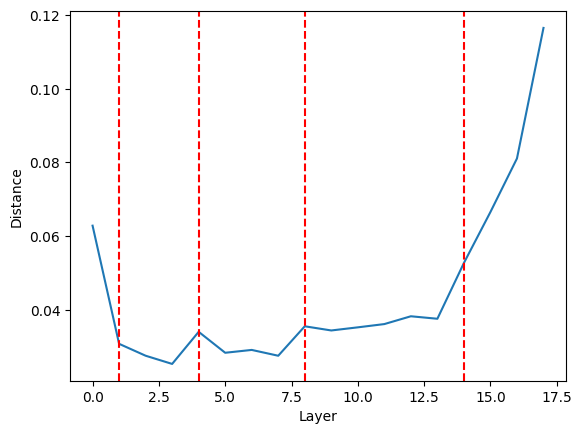

In [8]:
fig, ax = plt.subplots()
activations1 = ResNetActivations2(train_set.class_to_idx["apple"], classification_model, test_set, layers, n_points=100)
activations2 = ResNetActivations2(train_set.class_to_idx["bridge"], classification_model, test_set, layers, n_points=100)
distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    distances.append(distance.to(cpu))
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel("Layer")
ax.set_ylabel("Distance")

In [11]:
distances[-1]

tensor(0.1061)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


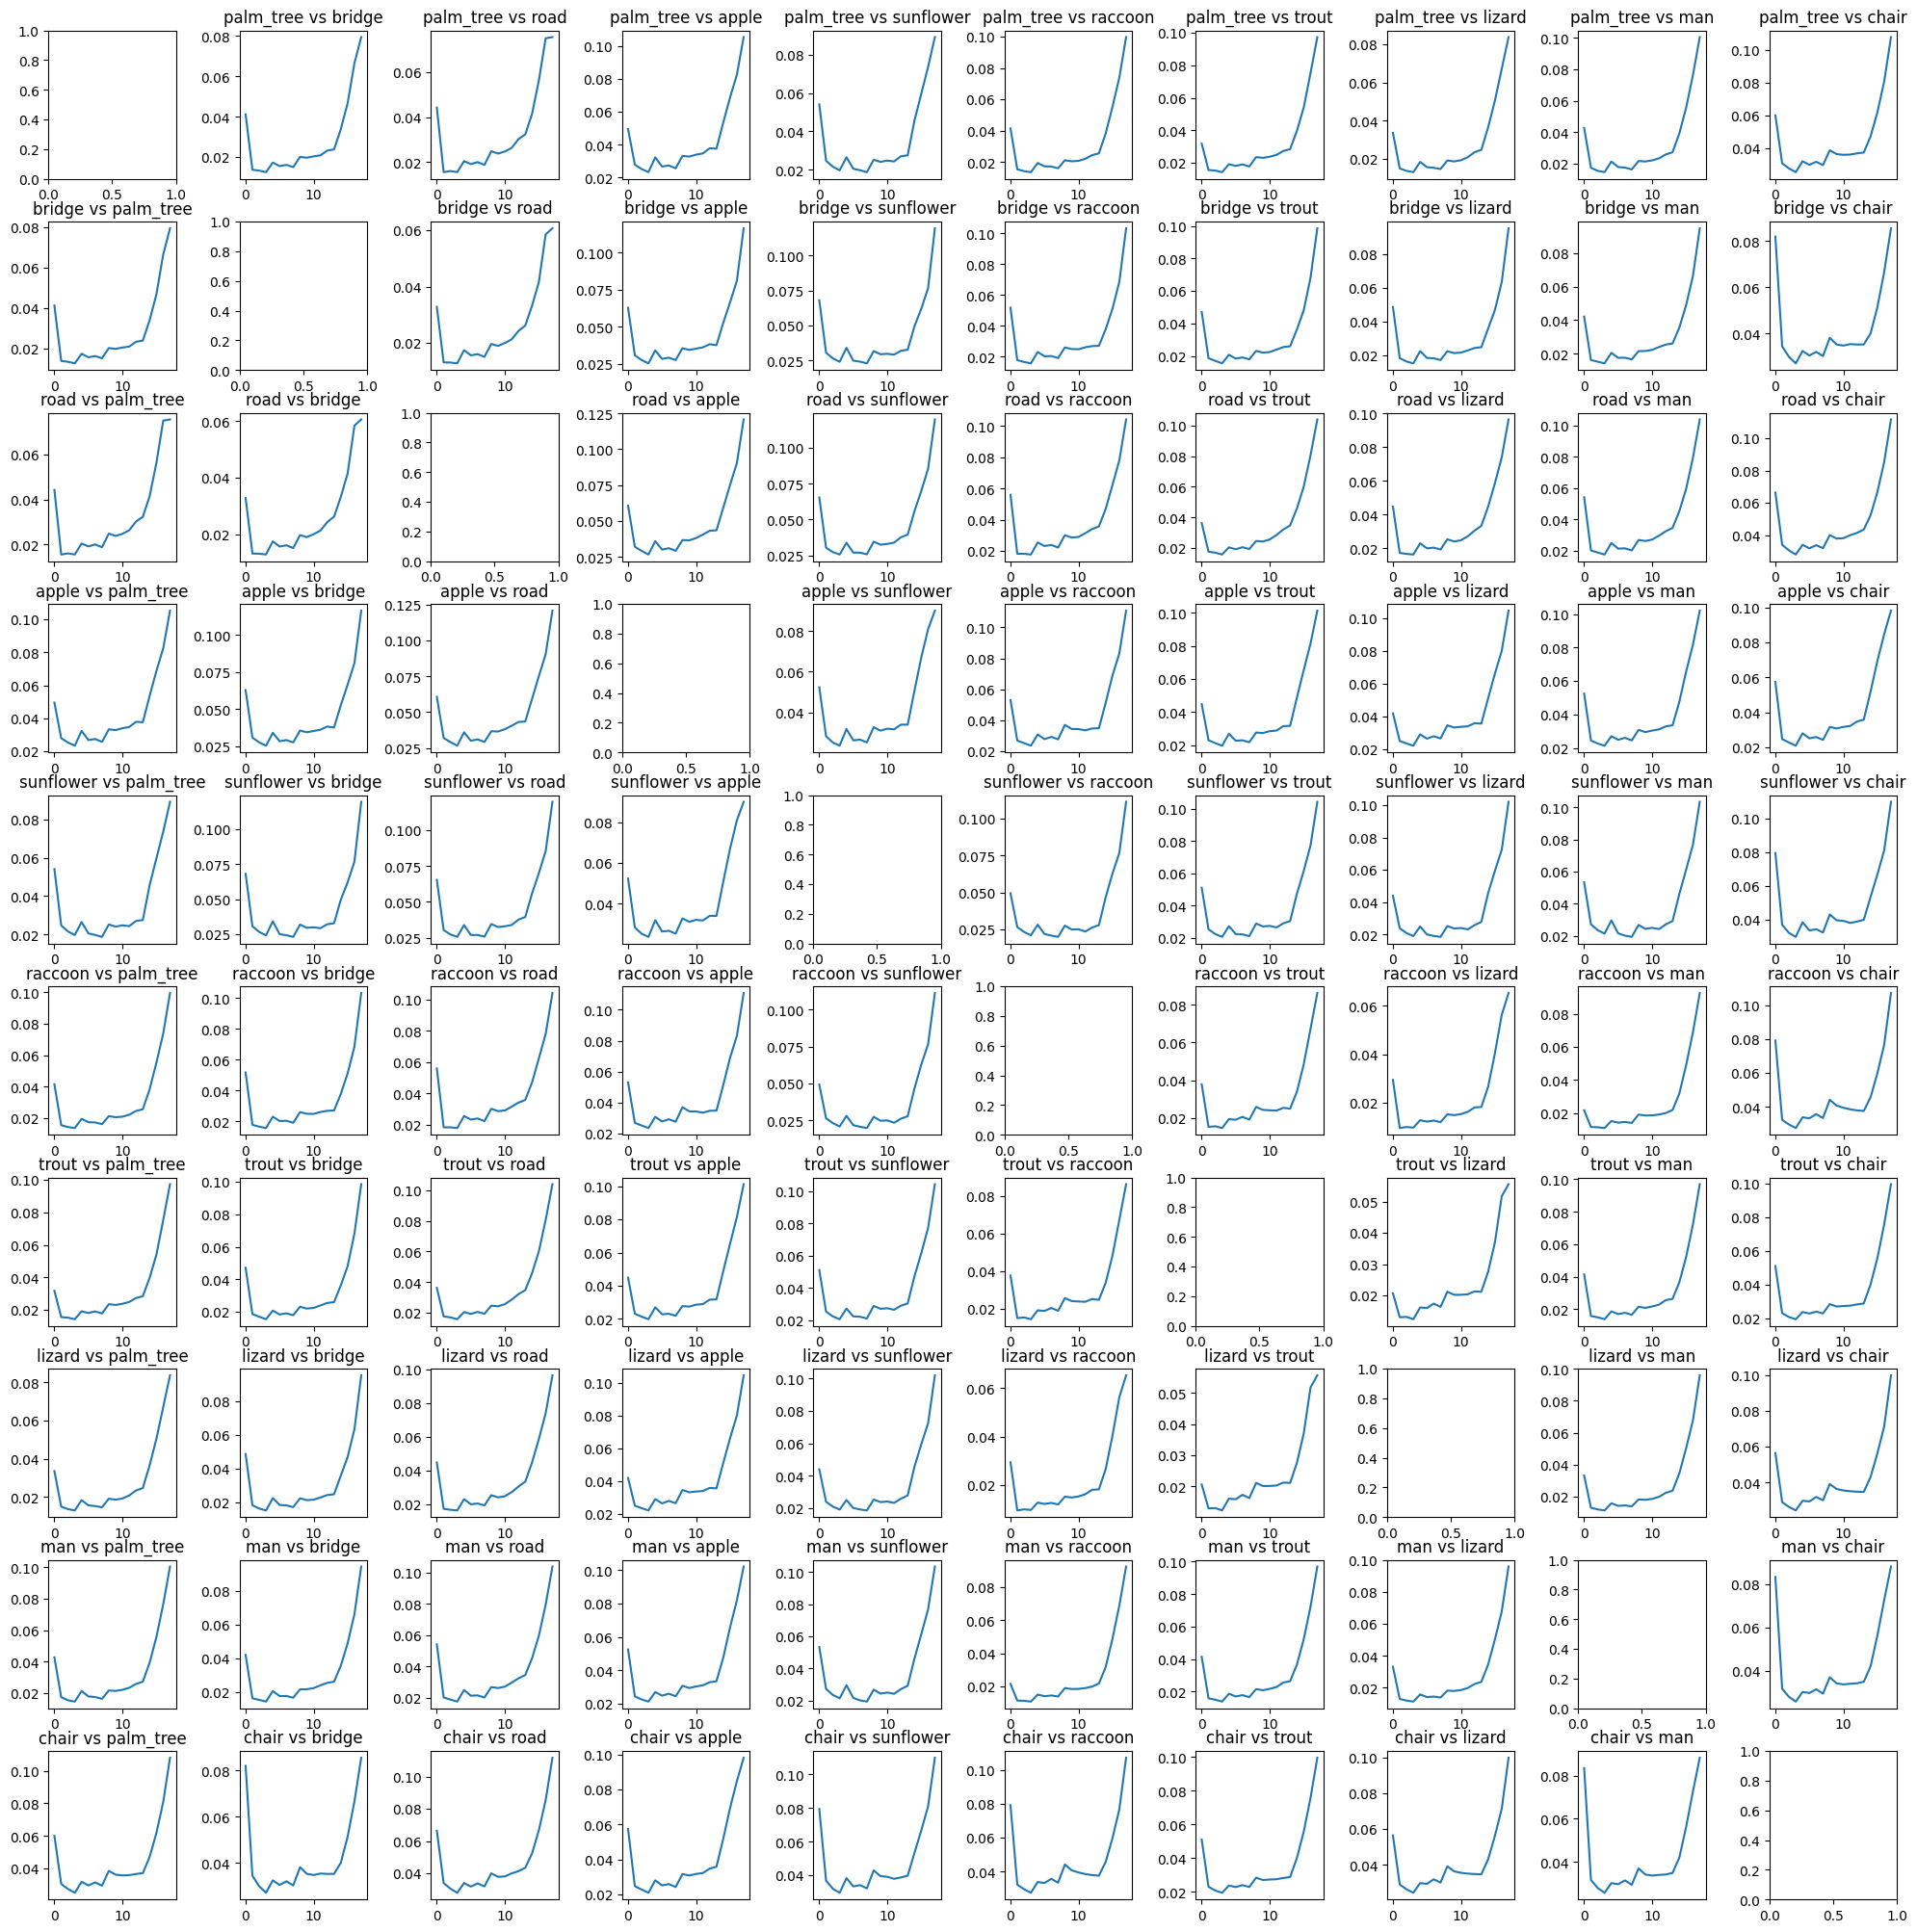

In [9]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for idx, i in enumerate(chosen_classes):
    activations1 = ResNetActivations2(i, classification_model, test_set, layers, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for jdx, j in enumerate(chosen_classes):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations2(j, classification_model, test_set, layers, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            centroid1 = act1.mean(dim=0)
            centroid2 = act2.mean(dim=0)
            distance = torch.dist(centroid1, centroid2, p=2)
            distances.append(distance.to(cpu))
            del act1, act2, centroid1, centroid2, distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[idx, jdx].plot(range(len(layers)), distances)
        ax[idx, jdx].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/distances_cifar100.pdf")

In [7]:
def ResNetActivations3(target_class, model, data, layers, n_points=100):
    """
    Returns the activations of the target class for the given layers.

    Args:
        target_class: The target
        class to get activations for.
        model: The model to get activations from.
        data: The data to get activations from.
        layers: The layers to get activations from.
        n_points: The number of points to get activations for.

    Returns:
        Generator of activations for each layer.
    """
    # Define callback function for layer hooks
    class_indices = [i for i, (_, label) in enumerate(data) if label == target_class]
    selected_indices = np.random.choice(class_indices, n_points, replace=False)
    selected_data = torch.utils.data.Subset(data, selected_indices)
    loader = torch.utils.data.DataLoader(selected_data, batch_size=n_points)
    activations = []
    def get_activation(name):
        def hook(model, input, output):
            # normalize output
            output1 = output
            activations.append(output1.detach())
        return hook
    
    for layer in layers:
        handle = layer.register_forward_hook(get_activation(layer))
        with torch.no_grad():
            for batch, _ in loader:
                model(batch.to(device))
        handle.remove()
        yield activations[0]
        del activations
        activations = []

In [13]:
activations1 = ResNetActivations3(train_set.class_to_idx["bear"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["cloud"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    print(f"Mean normalised cosine distances for layer {i+1}: {1 - distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised cosine distances for layer 1: 1.036865472793579
Mean normalised cosine distances for layer 2: 0.2637237310409546
Mean normalised cosine distances for layer 3: 0.4203495383262634
Mean normalised cosine distances for layer 4: 0.5882449150085449
Mean normalised cosine distances for layer 5: 0.9244479537010193


In [14]:
activations1 = ResNetActivations3(train_set.class_to_idx["bear"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["cloud"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
    print(f"Cosine Distance between centroids for layer {i+1}: {cos_distance.item()}")
    del act1, act2, centroid1, centroid2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Cosine Distance between centroids for layer 1: 1.180687665939331
Cosine Distance between centroids for layer 2: 0.025189995765686035
Cosine Distance between centroids for layer 3: 0.03600502014160156
Cosine Distance between centroids for layer 4: 0.1038205623626709
Cosine Distance between centroids for layer 5: 0.7748301029205322


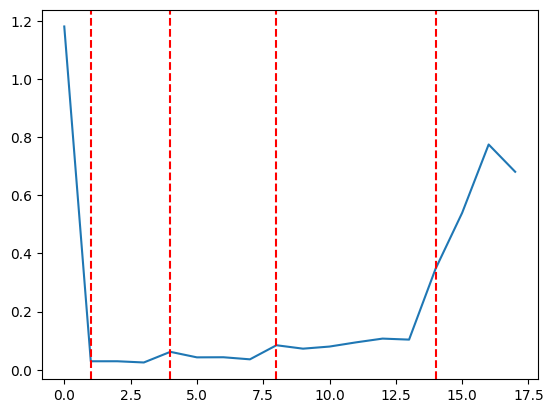

In [15]:
fig, ax = plt.subplots()
activations1 = ResNetActivations3(train_set.class_to_idx["bear"], classification_model, test_set, layers, n_points=100)
activations2 = ResNetActivations3(train_set.class_to_idx["cloud"], classification_model, test_set, layers, n_points=100)
distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    cos_distance = 1 - distances.mean()
    distances.append(cos_distance.to(cpu))
    del act1, act2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


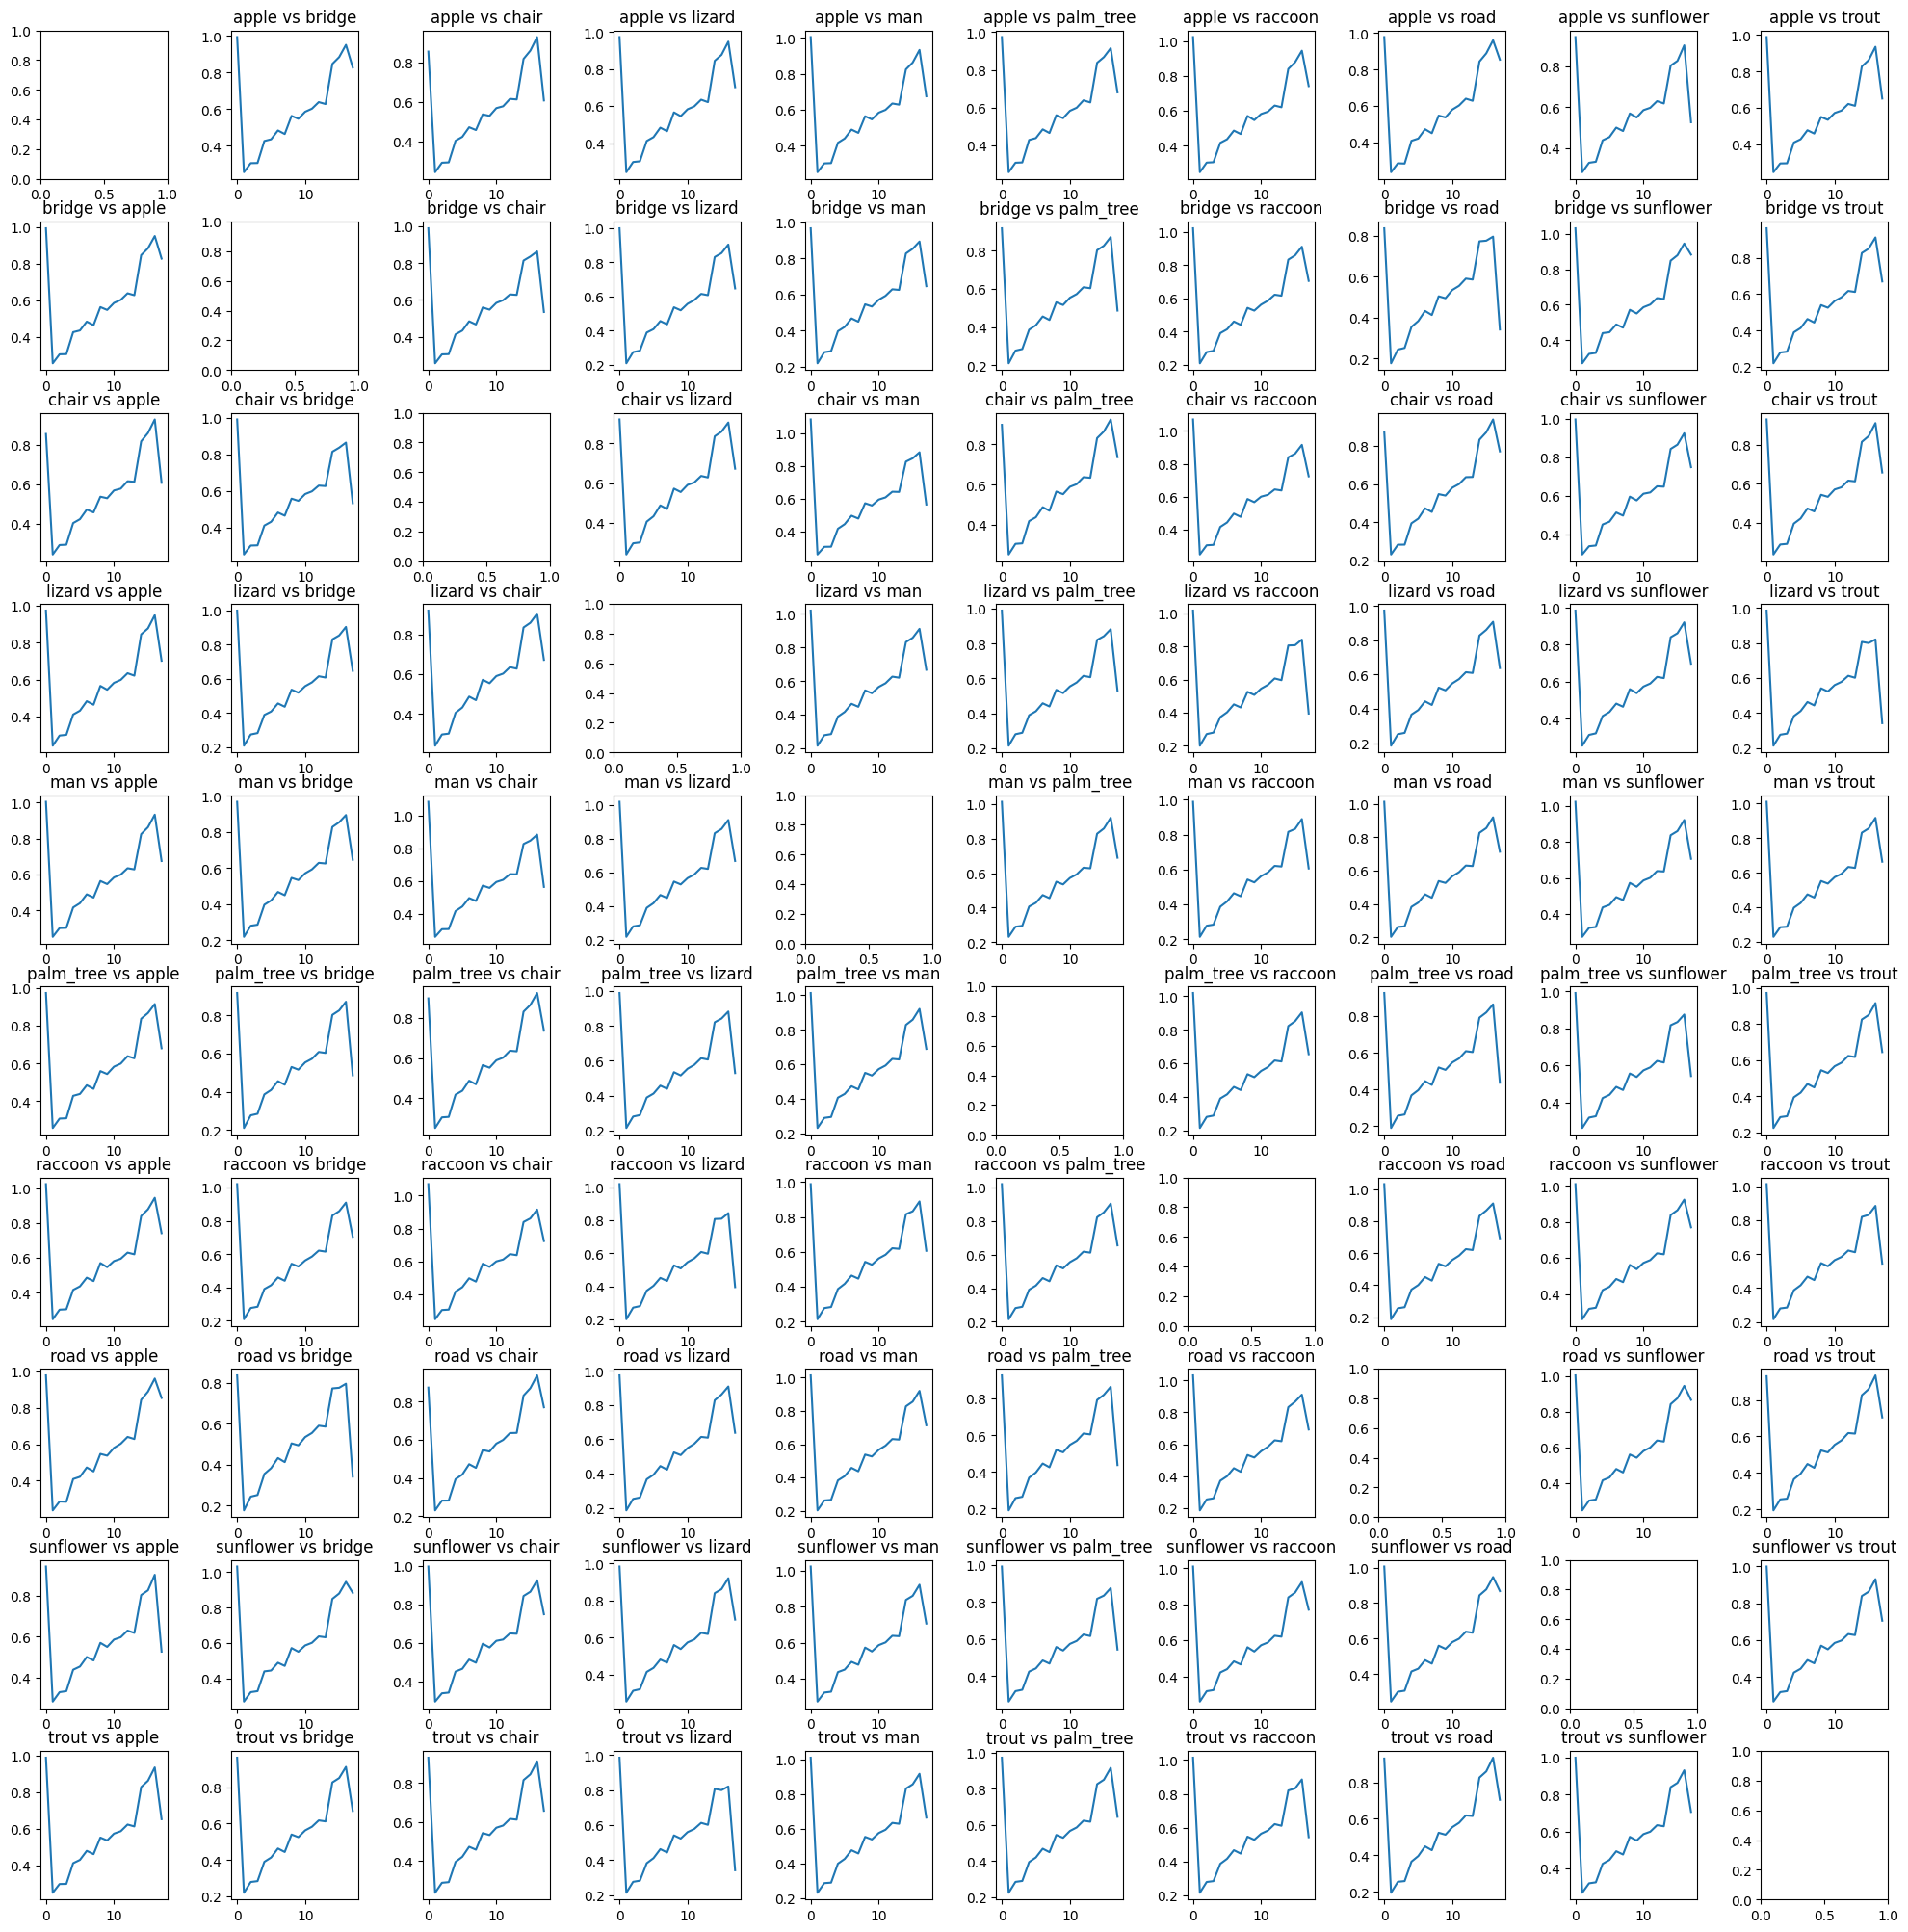

In [8]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for idx, i in enumerate(chosen_classes):
    activations1 = ResNetActivations3(i, classification_model, test_set, layers, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for jdx, j in enumerate(chosen_classes):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations3(j, classification_model, test_set, layers, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            cos_distance = 1 - torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
            cos_distance = cos_distance.mean()
            distances.append(cos_distance.to(cpu))
            del act1, act2, cos_distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[idx, jdx].plot(range(len(layers)), distances)
        ax[idx, jdx].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/cosine_distances_cifar100.pdf")

In [9]:
classification_model2 = torch.load('resnet50_cifar100_3_epochs.pth')
classification_model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
activations1 = ResNetActivations2(train_set.class_to_idx["bear"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["cloud"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.cdist(act1.view(100, -1), act2.view(100, -1))
    print(f"Mean normalised distances for layer {i+1}: {distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised distances for layer 1: 0.1400807946920395
Mean normalised distances for layer 2: 0.07404432445764542
Mean normalised distances for layer 3: 0.09338916093111038
Mean normalised distances for layer 4: 0.10980129987001419
Mean normalised distances for layer 5: 0.13630804419517517


In [18]:
activations1 = ResNetActivations2(train_set.class_to_idx["bear"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["cloud"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    print(f"Distance between centroids for layer {i+1}: {distance}")
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Distance between centroids for layer 1: 0.061481229960918427
Distance between centroids for layer 2: 0.019764510914683342
Distance between centroids for layer 3: 0.020629974082112312
Distance between centroids for layer 4: 0.025610962882637978
Distance between centroids for layer 5: 0.042738981544971466


In [10]:
layers2 = [  
            classification_model2.conv1, 
            classification_model2.layer1[0],
            classification_model2.layer1[1],
            classification_model2.layer1[2],
            classification_model2.layer2[0],
            classification_model2.layer2[1],
            classification_model2.layer2[2],
            classification_model2.layer2[3],
            classification_model2.layer3[0],
            classification_model2.layer3[1],
            classification_model2.layer3[2],
            classification_model2.layer3[3],
            classification_model2.layer3[4],
            classification_model2.layer3[5],
            classification_model2.layer4[0],
            classification_model2.layer4[1],
            classification_model2.layer4[2],
            classification_model2.fc
]

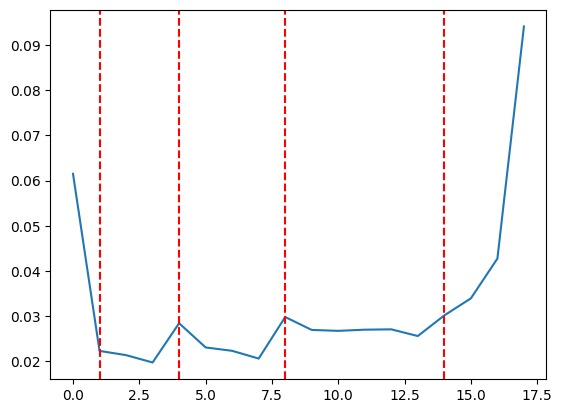

In [20]:
fig, ax = plt.subplots()
activations1 = ResNetActivations2(train_set.class_to_idx["bear"], classification_model2, test_set, layers2, n_points=100)
activations2 = ResNetActivations2(train_set.class_to_idx["cloud"], classification_model2, test_set, layers2, n_points=100)
distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    distances.append(distance.to(cpu))
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')

In [21]:
distances[-1]

tensor(0.0941)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


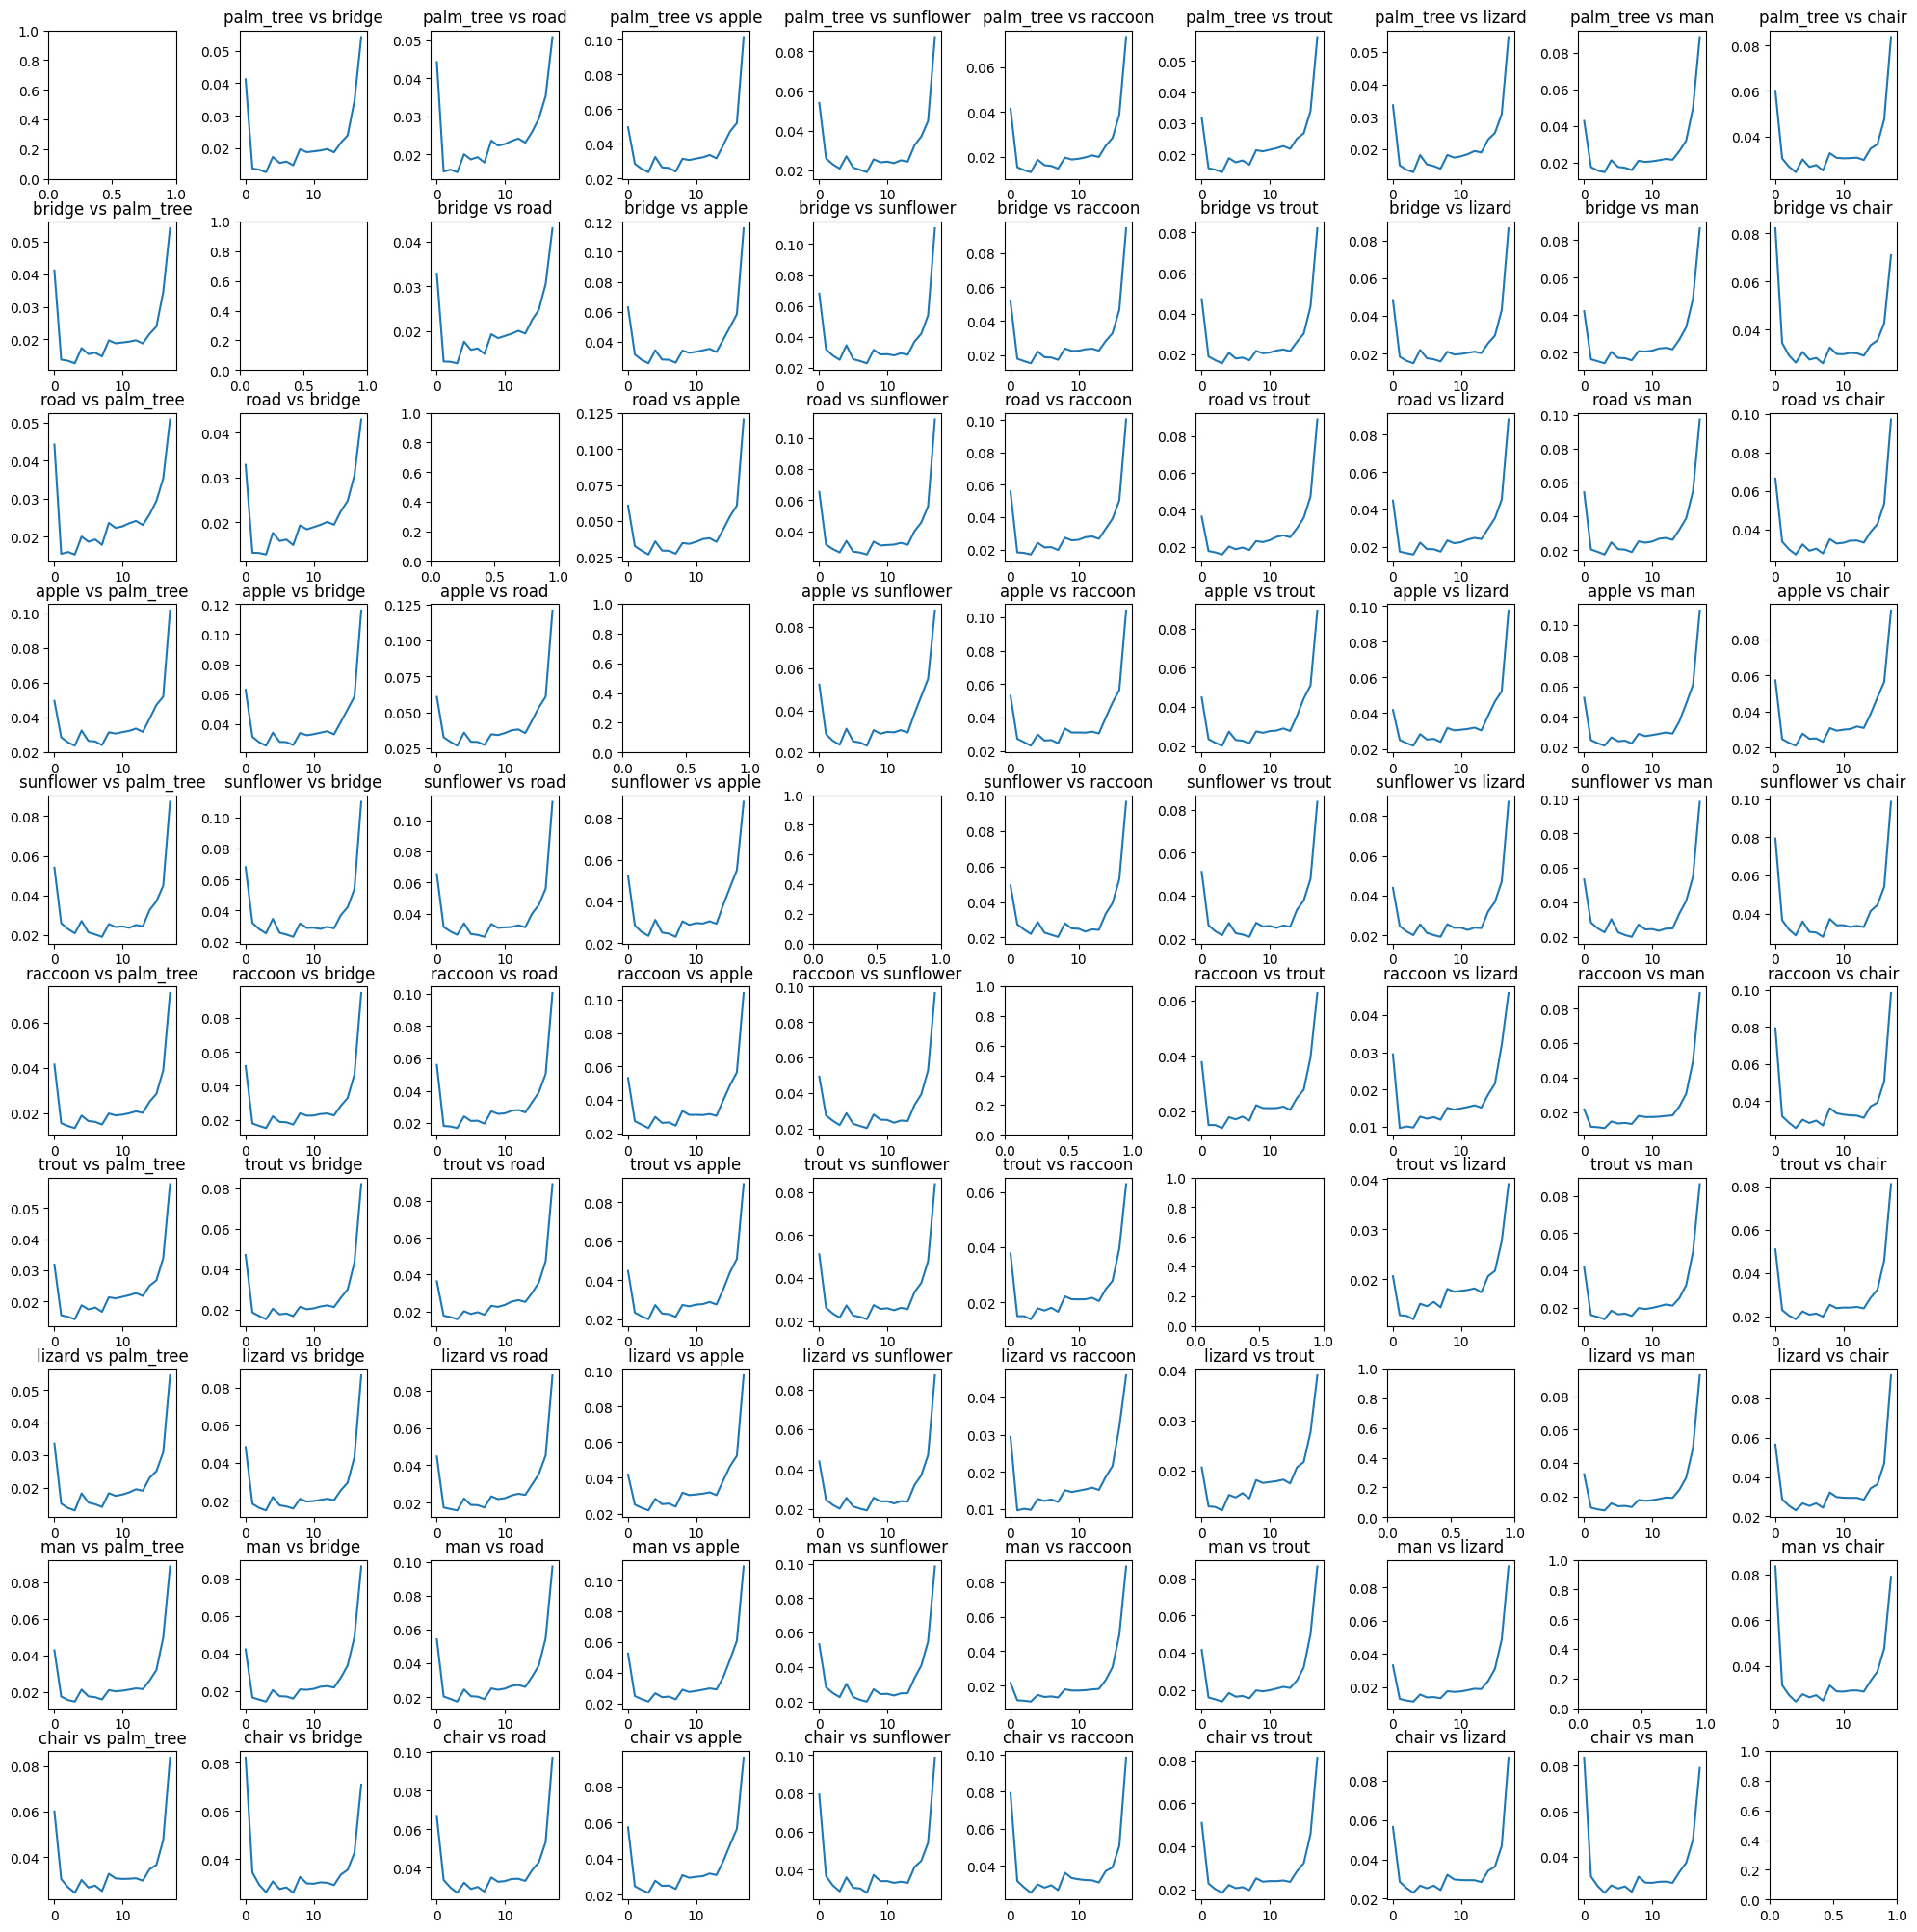

In [12]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for idx, i in enumerate(chosen_classes):
    activations1 = ResNetActivations2(i, classification_model2, test_set, layers2, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for jdx, j in enumerate(chosen_classes):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations2(j, classification_model2, test_set, layers2, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            centroid1 = act1.mean(dim=0)
            centroid2 = act2.mean(dim=0)
            distance = torch.dist(centroid1, centroid2, p=2)
            distances.append(distance.to(cpu))
            del act1, act2, centroid1, centroid2, distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[idx, jdx].plot(range(len(layers2)), distances)
        ax[idx, jdx].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/distances_cifar100_1_epoch.pdf")

In [22]:
activations1 = ResNetActivations3(train_set.class_to_idx["bear"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["cloud"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    print(f"Mean normalised cosine distances for layer {i+1}: {1 - distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised cosine distances for layer 1: 1.0368609428405762
Mean normalised cosine distances for layer 2: 0.2727247476577759
Mean normalised cosine distances for layer 3: 0.43527936935424805
Mean normalised cosine distances for layer 4: 0.6026461124420166
Mean normalised cosine distances for layer 5: 0.9551542401313782


In [23]:
activations1 = ResNetActivations3(train_set.class_to_idx["bear"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["cloud"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
    print(f"Cosine Distance between centroids for layer {i+1}: {cos_distance.item()}")
    del act1, act2, centroid1, centroid2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Cosine Distance between centroids for layer 1: 1.181479573249817
Cosine Distance between centroids for layer 2: 0.02564150094985962
Cosine Distance between centroids for layer 3: 0.03550910949707031
Cosine Distance between centroids for layer 4: 0.07561701536178589
Cosine Distance between centroids for layer 5: 0.6666074991226196


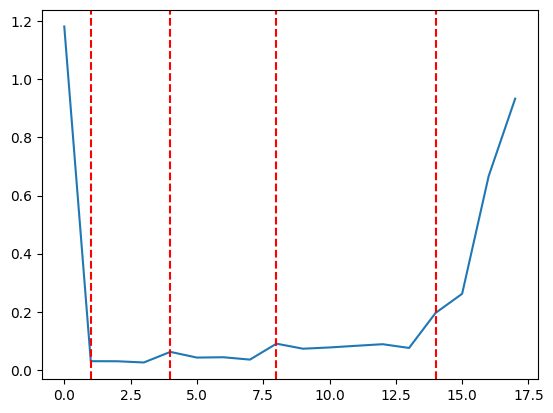

In [24]:
fig, ax = plt.subplots()
activations1 = ResNetActivations2(train_set.class_to_idx["bear"], classification_model2, test_set, layers2, n_points=100)
activations2 = ResNetActivations2(train_set.class_to_idx["cloud"], classification_model2, test_set, layers2, n_points=100)

distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
    distances.append(cos_distance.item())
    del act1, act2, centroid1, centroid2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
#print(distances)
ax.plot(range(len(layers)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


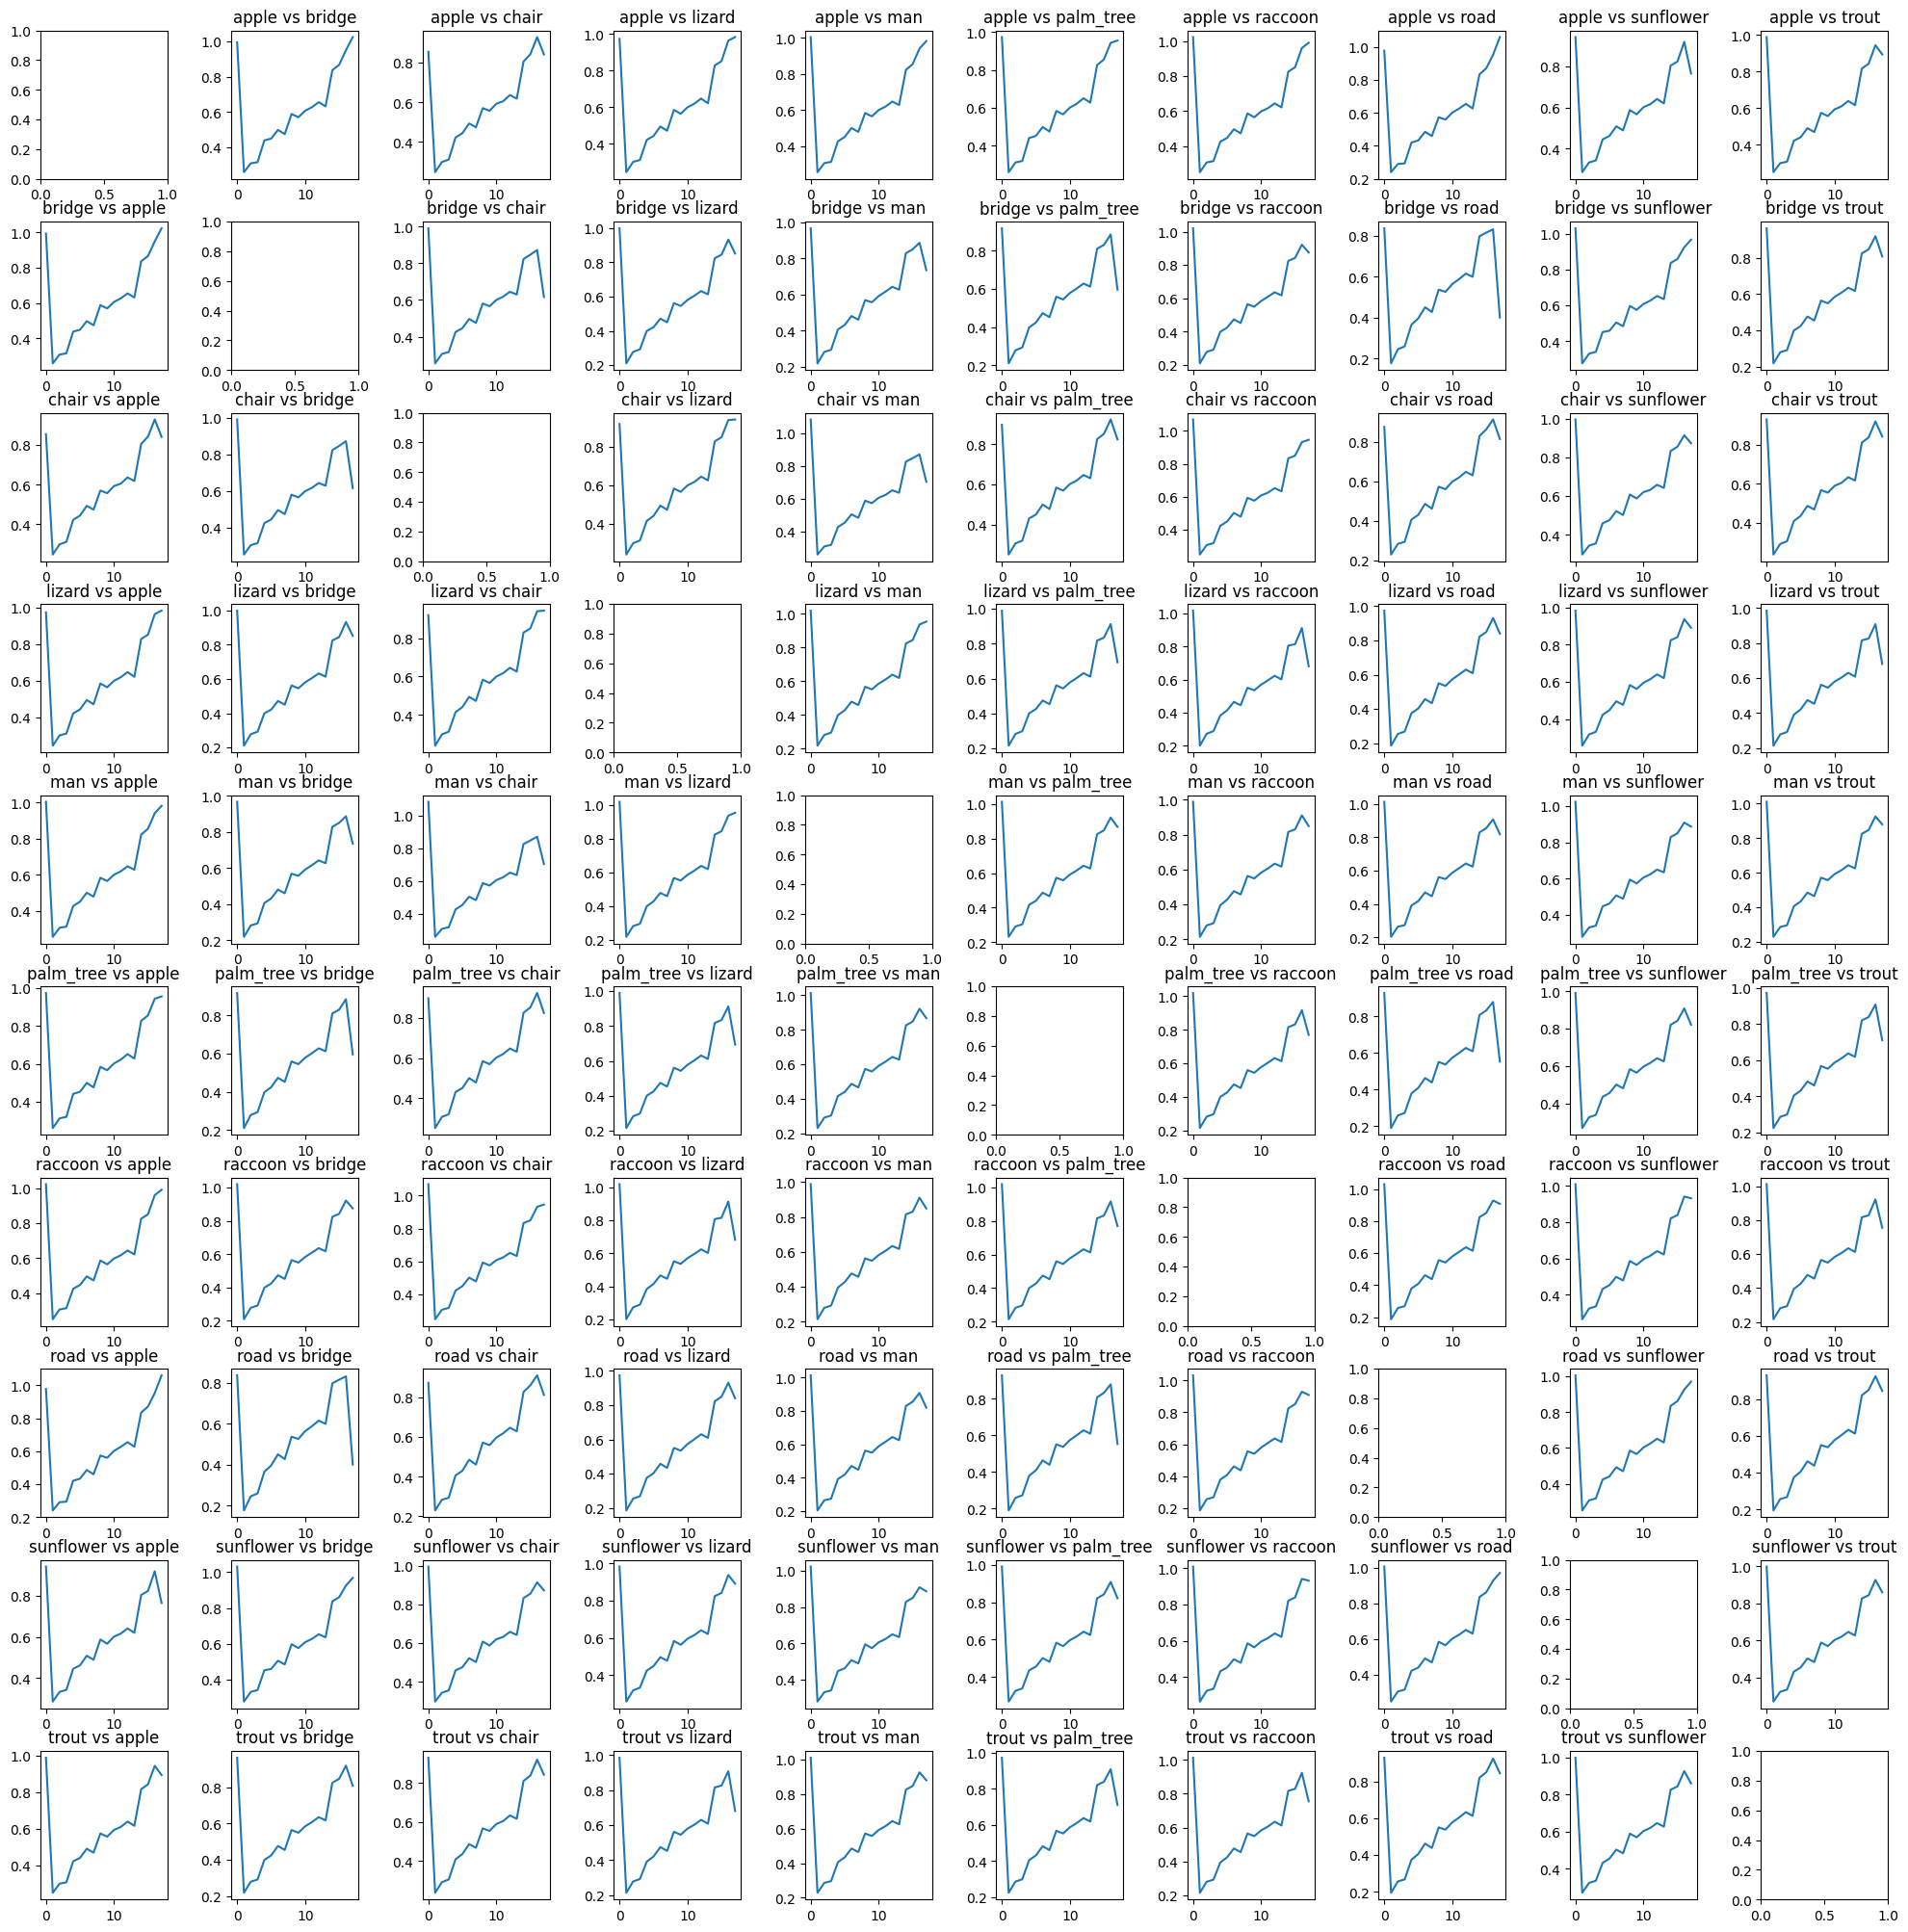

In [11]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for idx, i in enumerate(chosen_classes):
    activations1 = ResNetActivations3(i, classification_model2, test_set, layers2, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for jdx, j in enumerate(chosen_classes):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations3(j, classification_model2, test_set, layers2, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            cos_distance = 1 - torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
            cos_distance = cos_distance.mean()
            distances.append(cos_distance.to(cpu))
            del act1, act2, cos_distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[idx, jdx].plot(range(len(layers2)), distances)
        ax[idx, jdx].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/cosine_distances_cifar100_1_epoch.pdf")

In [6]:
class SplitResNet(nn.Module):
    def __init__(self, model, layer_hierarchy):
        super(SplitResNet, self).__init__()
        # self.model = model
        self.part1 = nn.Sequential()
        self.part2 = nn.Sequential()

        for i, (name, module) in enumerate(model.named_children()):
            if i == layer_hierarchy[0]:
                if len(layer_hierarchy) == 1:
                    self.part1.add_module(name, module)
                else:
                    former_module, latter_module = self._add_module(module, layer_hierarchy[1:])
                    self.part1.add_module(name, former_module)
                    self.part2.add_module(name, latter_module)
            elif i < layer_hierarchy[0]:
                self.part1.add_module(name, module)
            else:
                self.part2.add_module(name, module)

    def _add_module(self, module, layer_hierarchy):
        # print(layer_hierarchy, module)
        former_module, latter_module = nn.Sequential(), nn.Sequential()
        for i, (name, layer) in enumerate(module.named_children()):
            # print(name)
            if i == layer_hierarchy[0]:
                if len(layer_hierarchy) == 1:
                    # print('check')
                    former_module.add_module(name, layer)
                else:
                    # print('run')
                    former_layer, latter_layer = self._add_module(layer, layer_hierarchy[1:])
                    former_module.add_module(name, former_layer)
                    latter_module.add_module(name, latter_layer)
            elif i < layer_hierarchy[0]:
                former_module.add_module(name, layer)
            else:
                latter_module.add_module(name, layer)
        return former_module, latter_module

    def forward(self, x, mode='latter'):
        for module in self.part2[:-1]:
            x = module(x)
        x = torch.flatten(x, 1)
        return self.part2[-1](x)
        # if mode == 'latter':
        #     return self.part2(x)
        # if mode == 'former':
        #     return self.part1(x)
        # if mode == 'all_as_one_model':
        #     x = self.part1(x)
        #     x1 = self.part2(x)
        #     return x, x1
        # if mode == 'all_as_two_model':
        #     return self.part1(x), self.part2(x)

In [18]:
split_model = SplitResNet(classification_model, [7])
activations = []
hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
class_indices = [i for i, (_, label) in enumerate(test_set) if label == 59]
selected_index_1 = np.random.choice(class_indices)
class_indices.remove(selected_index_1)
selected_index_2 = np.random.choice(class_indices)
classification_model(test_set[selected_index_1][0].unsqueeze(0).to(device))
classification_model(test_set[selected_index_2][0].unsqueeze(0).to(device))
hook.remove()
activation1 = activations[0]
activation2 = activations[1]
interpolated_activation = activation1 + (activation2 - activation1)*0.5
output1 = split_model(interpolated_activation)
label = output1.argmax().item()
print(f"Interpolated label: {label}")

Interpolated label: 59


In [11]:
split_model = SplitResNet(classification_model, [8])
activations = []
hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
class_indices = [i for i, (_, label) in enumerate(test_set) if label == 59]
selected_index_1 = np.random.choice(class_indices)
class_indices.remove(selected_index_1)
selected_index_2 = np.random.choice(class_indices)
classification_model(test_set[selected_index_1][0].unsqueeze(0).to(device))
classification_model(test_set[selected_index_2][0].unsqueeze(0).to(device))
hook.remove()
activation1 = activations[0]
activation2 = activations[1]
interpolation_weights = torch.linspace(0, 1, 10).to(device)
for weight in interpolation_weights:
    interpolated_activation = torch.lerp(activation1, activation2, weight)
    output1 = split_model(interpolated_activation)
    label = output1.argmax().item()
    print(f"Interpolated label: {label}")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
Interpolated label: 56
Interpolated label: 56
Interpolated label: 56
Interpolated label: 56
Interpolated label: 56
Interpolated label: 56
Interpolated label: 56
Interpolated label: 56
Interpolated label: 56
Interpolated label: 29


In [9]:
def class_convexity(target_class, layer, n_pairs=25):
    split_model = SplitResNet(classification_model, [layer])
    activations = []
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == target_class]
    hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
    num_success = 0
    for _ in range(n_pairs):
        selected_index_1 = np.random.choice(class_indices)
        class_indices.remove(selected_index_1)
        selected_index_2 = np.random.choice(class_indices)
        class_indices.remove(selected_index_2)
        classification_model(train_set[selected_index_1][0].unsqueeze(0).to(device))
        classification_model(train_set[selected_index_2][0].unsqueeze(0).to(device))
        activation1 = activations[0]
        activation2 = activations[1]
        interpolation_weights = torch.linspace(0, 1, 10).to(device)
        interpolated_labels = []
        for weight in interpolation_weights:
            interpolated_activation = torch.lerp(activation1, activation2, weight)
            output1 = split_model(interpolated_activation)
            label = output1.argmax().item()
            interpolated_labels.append(label)
        if all([label == interpolated_labels[0] for label in interpolated_labels]):
            num_success += 1
        activations = []
    hook.remove()
    del split_model, activations, interpolated_activation, interpolated_labels, interpolation_weights, activation1, activation2
    torch.cuda.empty_cache()
    return num_success / n_pairs

In [7]:
def class_convexity2(target_class, layer, n_pairs=25):
    split_model = SplitResNet(classification_model2, [layer])
    activations = []
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == target_class]
    hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
    num_success = 0
    for _ in range(n_pairs):
        selected_index_1 = np.random.choice(class_indices)
        class_indices.remove(selected_index_1)
        selected_index_2 = np.random.choice(class_indices)
        class_indices.remove(selected_index_2)
        classification_model2(train_set[selected_index_1][0].unsqueeze(0).to(device))
        classification_model2(train_set[selected_index_2][0].unsqueeze(0).to(device))
        activation1 = activations[0]
        activation2 = activations[1]
        interpolation_weights = torch.linspace(0, 1, 10).to(device)
        interpolated_labels = []
        for weight in interpolation_weights:
            interpolated_activation = torch.lerp(activation1, activation2, weight)
            output1 = split_model(interpolated_activation)
            label = output1.argmax().item()
            interpolated_labels.append(label)
        if all([label == interpolated_labels[0] for label in interpolated_labels]):
            num_success += 1
        activations = []
    hook.remove()
    del split_model, activations, interpolated_activation, interpolated_labels, interpolation_weights, activation1, activation2
    torch.cuda.empty_cache()
    return num_success / n_pairs

In [11]:
print(class_convexity(78, 5))
torch.cuda.empty_cache()

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.24


c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


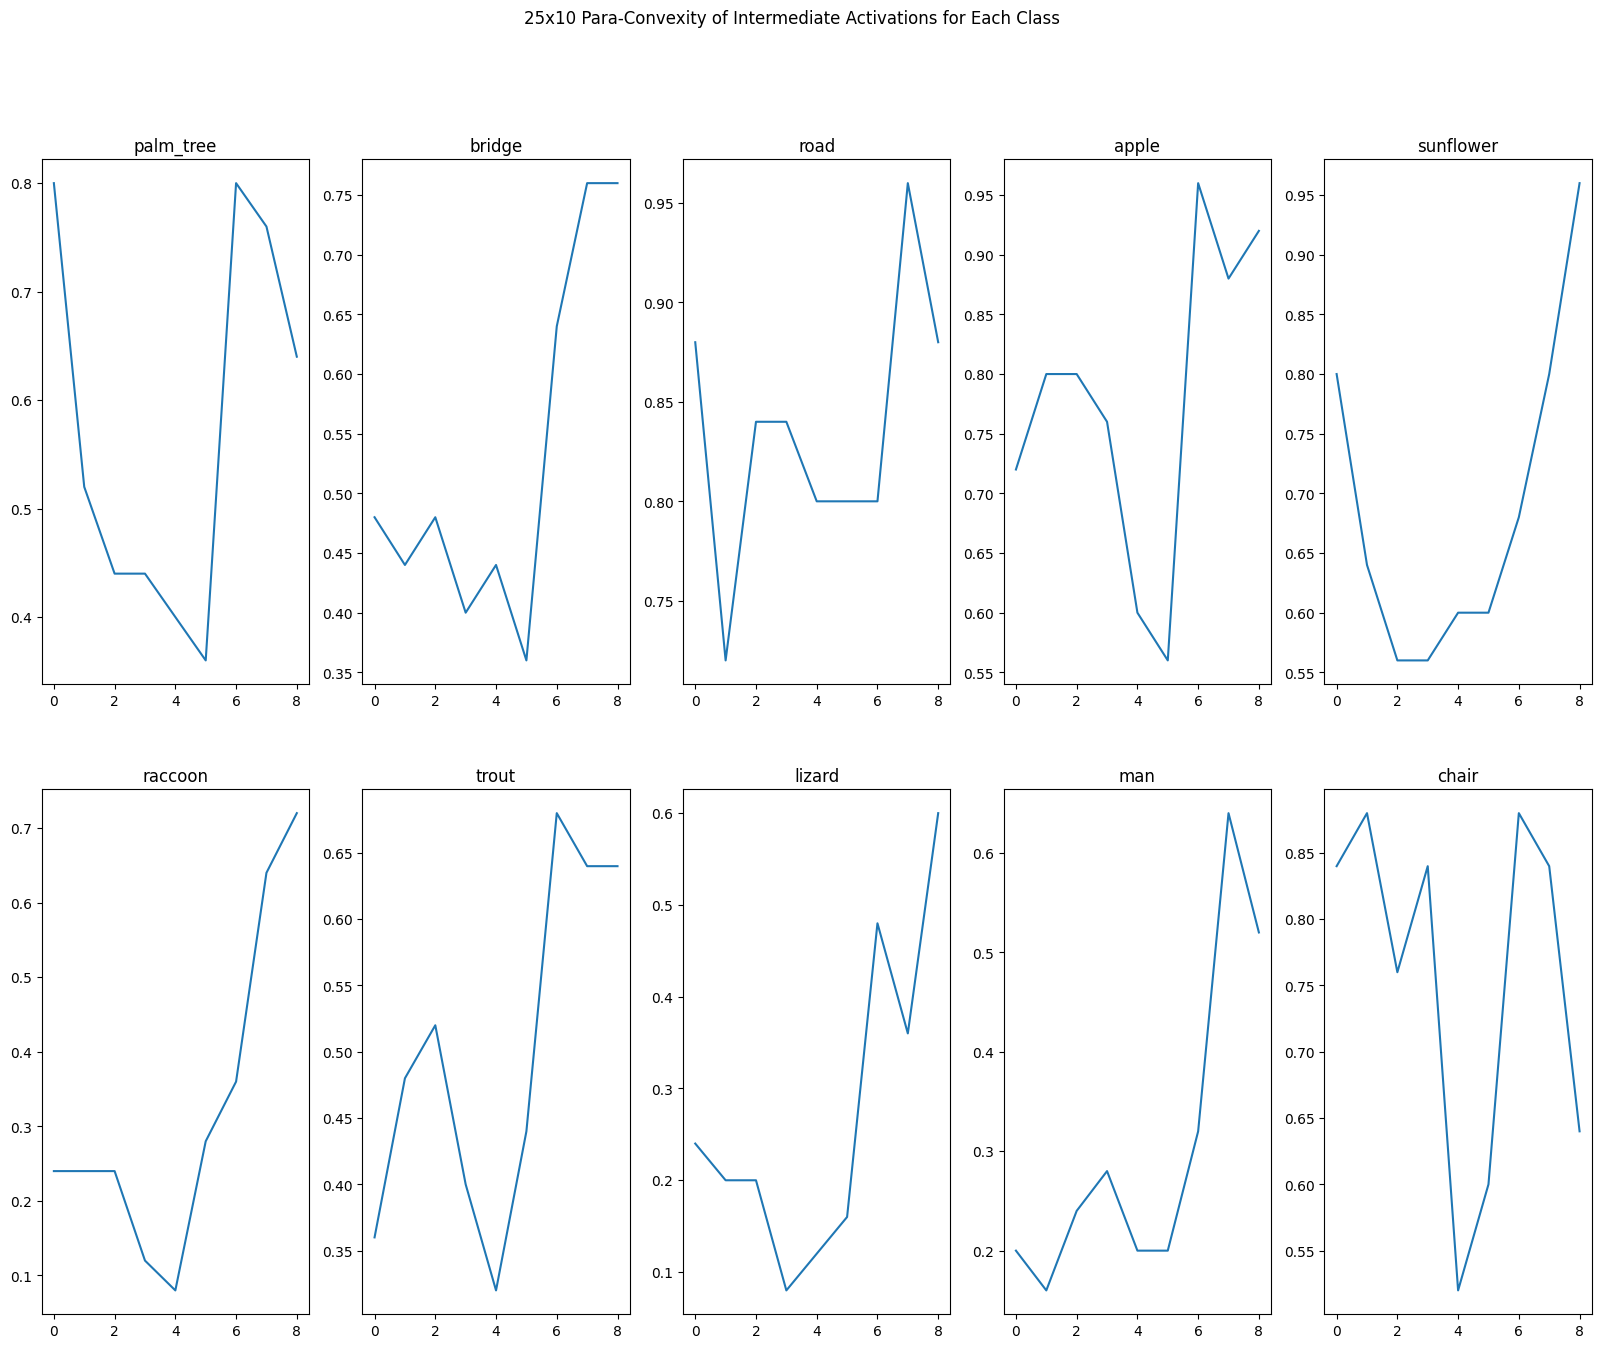

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
fig.suptitle("25x10 Para-Convexity of Intermediate Activations for Each Class")
for i, class_idx in enumerate(chosen_classes):
    row = i // 5
    col = i % 5
    class_name = [k for k, v in train_set.class_to_idx.items() if v == class_idx][0]
    ax[row, col].plot(range(9), [class_convexity(class_idx, layer) for layer in range(9)])
    ax[row, col].set_title(class_name)

In [14]:
fig.savefig("figures/para_convexity_cifar100.pdf")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


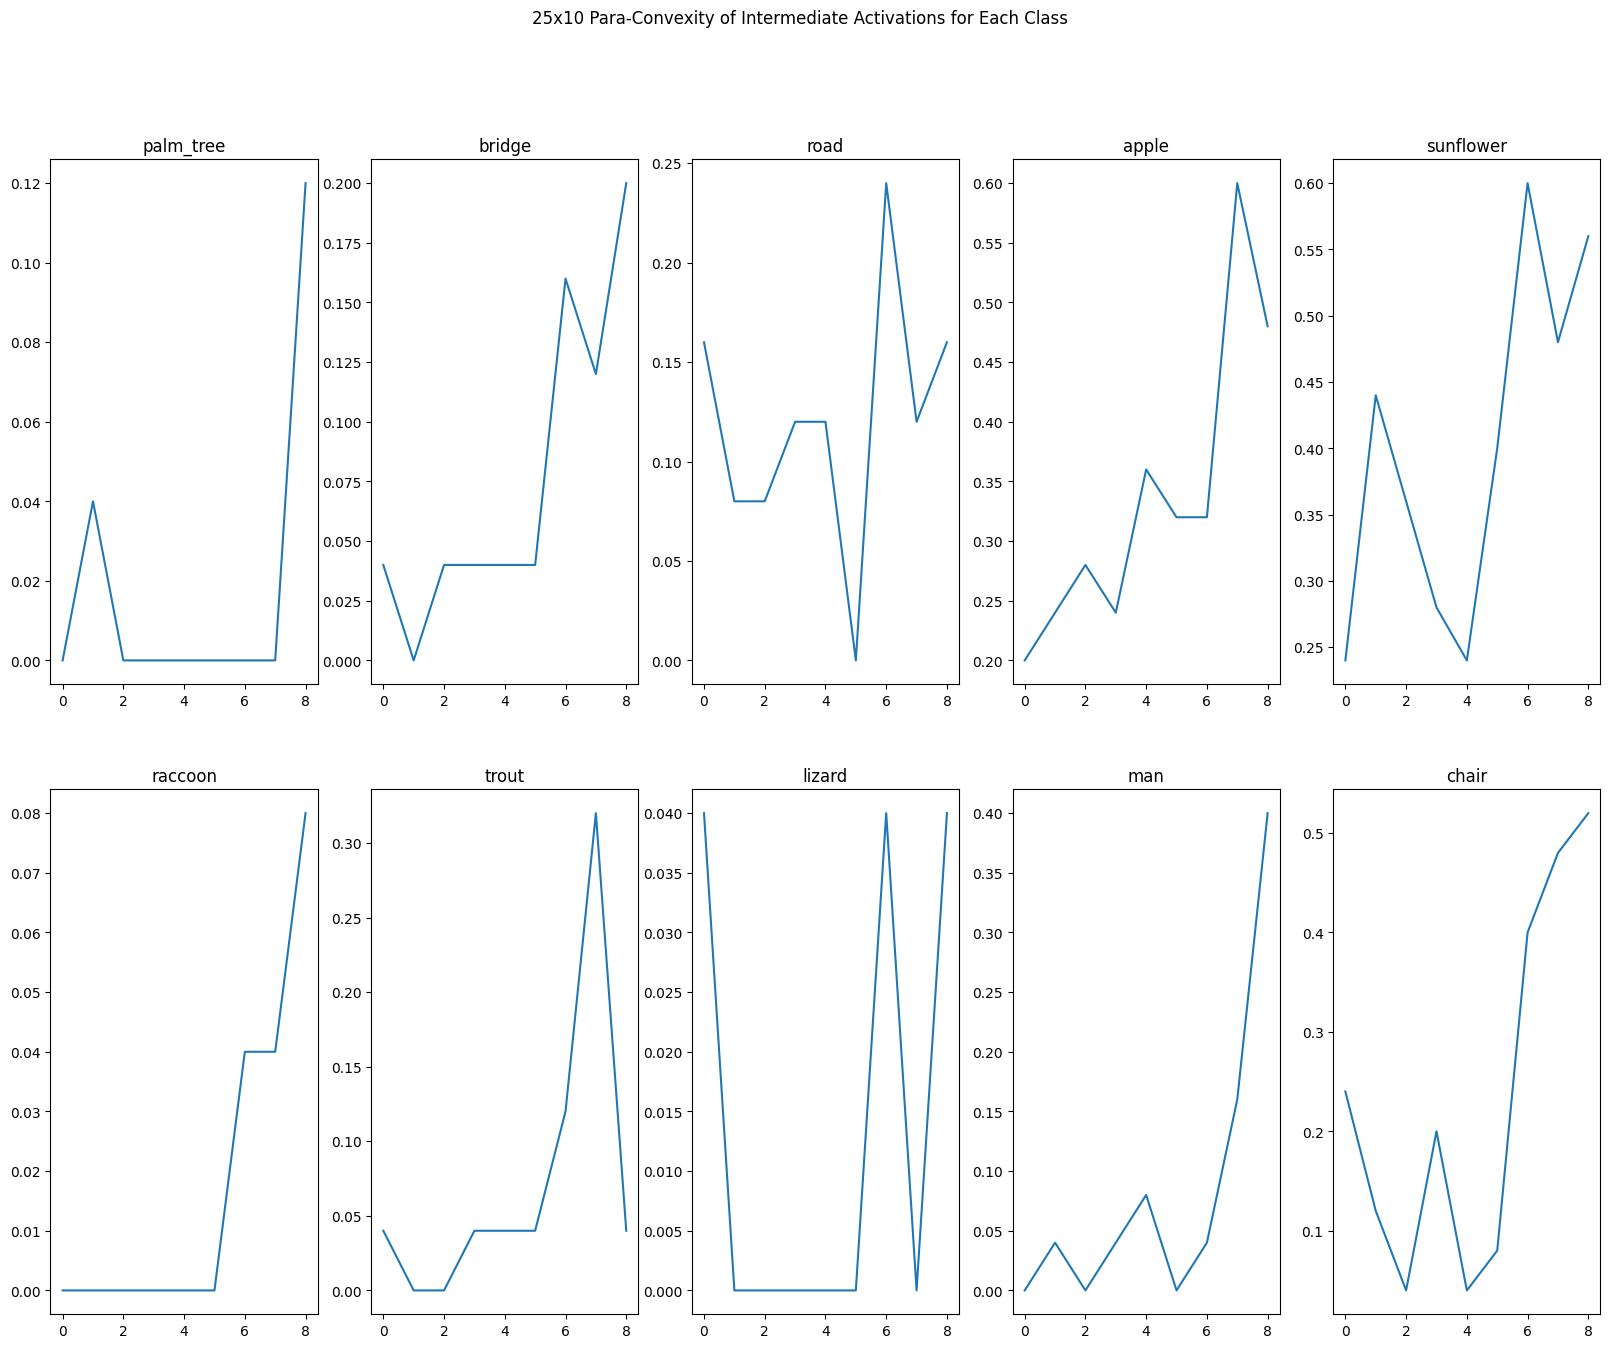

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
fig.suptitle("25x10 Para-Convexity of Intermediate Activations for Each Class")
for i, class_idx in enumerate(chosen_classes):
    row = i // 5
    col = i % 5
    class_name = [k for k, v in train_set.class_to_idx.items() if v == class_idx][0]
    ax[row, col].plot(range(9), [class_convexity2(class_idx, layer) for layer in range(9)])
    ax[row, col].set_title(class_name)

In [11]:
fig.savefig("figures/para_convexity_cifar100_1_epoch.pdf")

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [8]:
from torch.utils.data import Subset, DataLoader

# Define the number of samples to be taken from each class
num_samples_per_class = 15

# Create a list to store the indices of the selected samples
selected_indices = []

# Iterate over each class
for class_label in chosen_classes:
    # Get the indices of samples belonging to the current class
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == class_label]
    
    # Randomly select num_samples_per_class indices from the class_indices
    selected_indices.extend(np.random.choice(class_indices, num_samples_per_class, replace=False).tolist())

# Create a Subset of the train_set using the selected indices
subset = Subset(train_set, selected_indices)

# Create a DataLoader to load the subset into a batch
batch_size = 150 # 25 samples from each class, total 250 samples
data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
import umap

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to

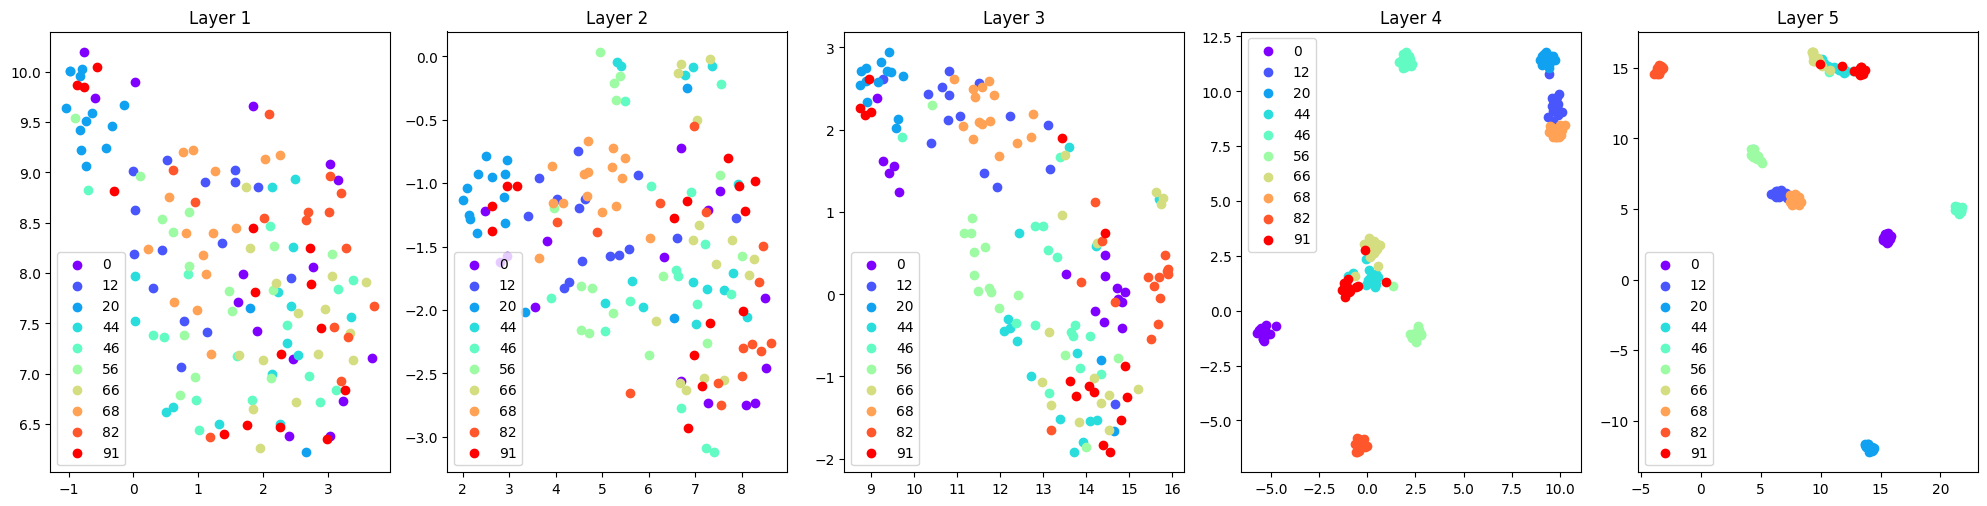

In [10]:
layers_arr = [classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4, classification_model.fc]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.tight_layout()
for i, layer in enumerate(layers_arr):
    activations = []
    hook = layer.register_forward_hook(lambda self, input, output: activations.append(output.detach()))
    for batch, labels in data_loader:
        classification_model(batch.to(device))
    hook.remove()
    activations = activations[0].view(activations[0].size(0), -1)
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
    umap_activations = umap_model.fit_transform(activations.to(cpu))
    unique_labels = list(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    for j, label in enumerate(unique_labels):
        indices = labels == label
        ax[i].scatter(umap_activations[indices, 0], umap_activations[indices, 1], color=colors[j], label=label)
    ax[i].set_title(f"Layer {i+1}")
    ax[i].legend()
    del activations
    torch.cuda.empty_cache()

In [15]:
for batch, labels in data_loader:
    print(np.unique(labels.numpy(), return_counts=True))

(array([ 0, 12, 20, 44, 46, 56, 66, 68, 82, 91], dtype=int64), array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15], dtype=int64))


c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [11]:
fig.savefig("figures/umap_cifar100.pdf")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to

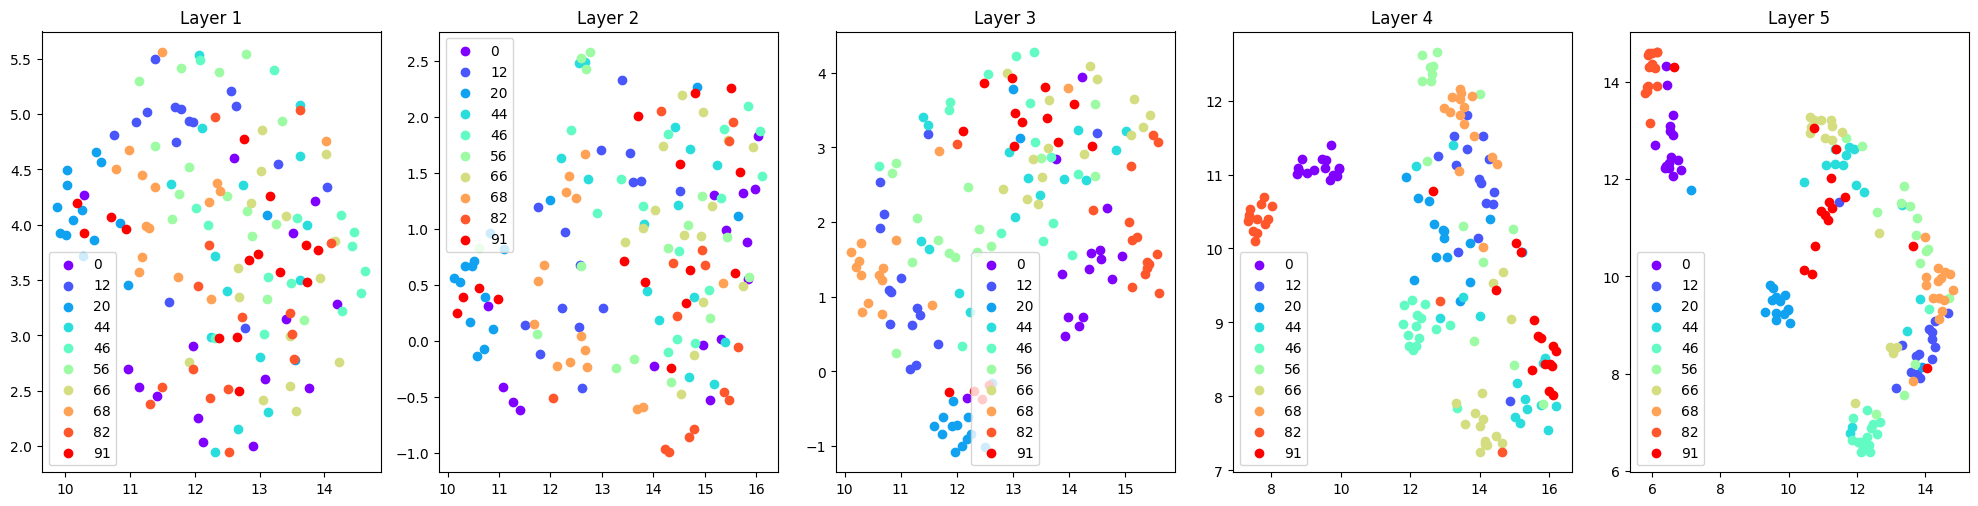

In [12]:
layers_arr2 = [classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4, classification_model2.fc]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.tight_layout()

for i, layer in enumerate(layers_arr2):
    activations = []
    hook = layer.register_forward_hook(lambda self, input, output: activations.append(output.detach()))
    for batch, labels in data_loader:
        classification_model2(batch.to(device))
    hook.remove()
    activations = activations[0].view(activations[0].size(0), -1)
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
    umap_activations = umap_model.fit_transform(activations.to(cpu))
    unique_labels = list(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    for j, label in enumerate(unique_labels):
        indices = labels == label
        ax[i].scatter(umap_activations[indices, 0], umap_activations[indices, 1], color=colors[j], label=label)
    ax[i].set_title(f"Layer {i+1}")
    ax[i].legend()
    del activations
    torch.cuda.empty_cache()

In [13]:
fig.savefig("figures/umap_cifar100_5_epoch.pdf")